# Les données

On utilise les librairies Python suivantes:
- __Panda__: pour la manipulation des dataset
- __Numpy__: pour la minupulation des tableau
- __Matplotlib__: pour l'affichage de graphique

## Vision globale

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Lecture des données d'entrainement avec panda. Affichage des premières lignes pour avoir une idée des données.

In [2]:
globalVisionData = pd.read_csv('data/train.csv')
display(globalVisionData.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
globalVisionData.shape

(10886, 12)

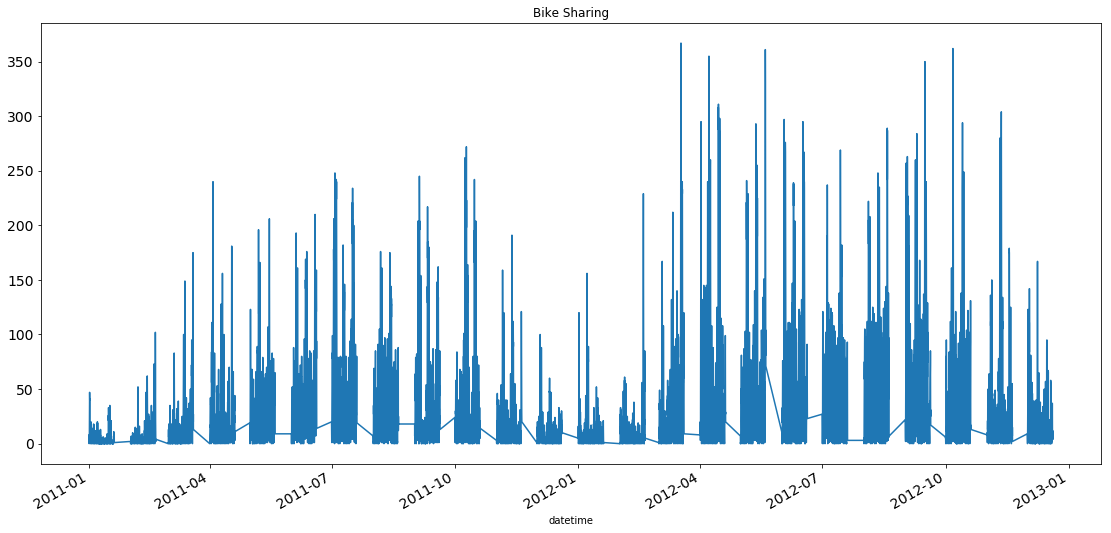

In [4]:
globalVisionData.datetime = pd.to_datetime(globalVisionData.datetime)
globalVisionData.index = globalVisionData.datetime

globalVisionData.casual.plot(figsize=(19,9), title="Bike Sharing", fontsize=14)
plt.show()

## Corrélation

On utilise la libraire `seaborn` pour créer une heatmap représentant la corrélation des attributs avec l'attribut `count`. Pour calculer la corrélation, on utilise la fonction `corr()` de la librairie `pandas` sur notre dataset.

In [5]:
import seaborn as sn

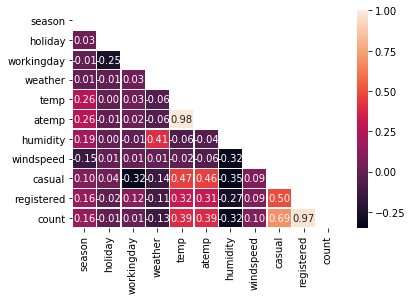

In [6]:
corr = globalVisionData.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sn.heatmap(corr, annot=True, mask=mask, fmt=".2f", linewidths=0.3)

plt.rcParams["figure.figsize"] = [16,9]
plt.show()

## Visualisation des locations en fonction de la température

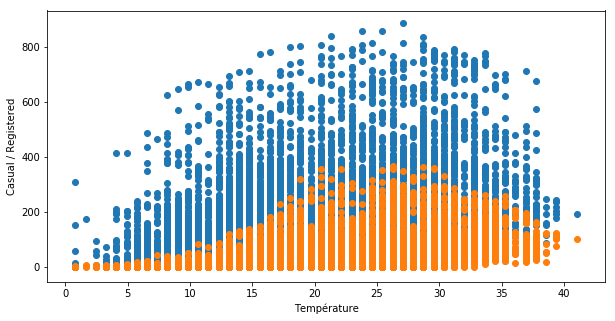

In [7]:
plt.rcParams["figure.figsize"] = [10,5]

plt.scatter(globalVisionData.temp, globalVisionData.registered)
plt.scatter(globalVisionData.temp, globalVisionData.casual)
plt.ylabel("Casual / Registered")
plt.xlabel("Température")
plt.show()

# Traitement des données

## Importation des données

In [8]:
dataTrain = pd.read_csv('data/train.csv')
dataTest = pd.read_csv('data/test.csv')

## Association des données d'entrainnement et de test

In [9]:
data = dataTrain.append(dataTest, sort=True)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

## Création de nouvelles colonnes à partir de la colonne "datetime"

In [10]:
import calendar
from datetime import datetime

data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

## Classification des colonnes

Nous avons donc 3 types de valeurs différentes:
- Les attributs que l'on nomme `categoricalAttributeNames`: ce sont des entiers qui représentent des catégories (par exemple, season=1 représente le premier quart de l'année).
- les attributs numériques que l'on nomme `numericalAttributeNames`: ce sont des float qui représente une mesure numérique.
- les attributs qu'on ne souhaite pas conserver dans l'entrainnement du model (que l'on nomme) `dropAttributes` car:
    - c'est les attributs que l'on souhaite prédire (l'attribut count)
    - C'est des attributs redondants (par exemple datetime)

In [11]:
categoricalAttributeNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalAttributeNames = ["temp","humidity","windspeed","atemp"]
dropAttributes = ['casual',"count","datetime","date","registered"]

print(data.dtypes)

atemp         float64
casual        float64
count         float64
datetime       object
holiday         int64
humidity        int64
registered    float64
season          int64
temp          float64
weather         int64
windspeed     float64
workingday      int64
date           object
hour            int64
year           object
weekday         int64
month           int64
dtype: object


Via la librairie `pandas`, on cast le type d'attribut vers `category` pour tous les attributs de la liste `categoricalAttributeNames`

In [12]:
for var in categoricalAttributeNames:
    data[var] = data[var].astype("category")

## Random forest pour l'attribut windspeed

Comme mentionner dans le rapport précédent, le dataset n'a pas de valeurs manquantes. Par contre l'attribut `windspeed` possède beaucoup de valeur égale à 0. Nous pourrions appliquer un algorithme RandomForest pour que l'attribut `windspeed` soit plus représentatif.

In [13]:
# TODO

# Prédiction

## RMSLE Scorer

Afin de juger de la qualité de nos prédictions pour chacun des différents modèles, nous avons défini un RSMLE scorer:

In [28]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Ce scorer nous retourne une valeur qui exprime de la dissimilarité entre notre prédiction (attribut `y`) et les valeurs réelles (attribut `y_`).

## Séparation des données d'entrainnement et de test 

In [15]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]

## Séparation des données d'entrainnement

On veut séparer nos données d'entrainnement en deux afin de créer un set de données de validation. On utilise la fonction `train_test_split()` de la librairie `sklearn` (30% des valeurs seront conserver à des fins de validation).

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(dataTrain, yLabels, test_size=0.3, random_state=23)

## Suppression de certains attributs

Comme expliquer çi-dessu, on supprime les attributs qu'on ne souhaite pas conserver dans l'entrainnement du model à partir de la liste `dropAttributes`.

In [17]:
dataTrain  = dataTrain.drop(dropAttributes,axis=1)
dataTest  = dataTest.drop(dropAttributes,axis=1)
X_train = X_train.drop(dropAttributes,axis=1)
X_validate = X_validate.drop(dropAttributes,axis=1)

## Modèle de régression linéaire

Dans un premier temps, on initialise et on entraine le modèle avec `X_train`, `y_train` (70% des données d'entrainement.

In [18]:
from sklearn.linear_model import LinearRegression

# Initialisation du modèle
lModel = LinearRegression()

# Entrainnement du model
lModel.fit(X = X_train,y = np.log1p(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Dans un second temps, on fait une prédiction sur les 30% de données restante.

In [40]:
# Prédiction
preds = lModel.predict(X=X_validate)

On applique notre RMSLE Scorer:

In [41]:
print ("RMSLE Value For Linear Regression: ", rmsle(y_validate, np.exp(preds)))

[0.5519556  0.53175815 0.62368105 ... 0.40919263 0.12760654 0.67082232]
RMSLE Value For Linear Regression:  1.022997786210461


## Validation graphique du modèle de regression linéaire

[Text(0.5, 1.0, "Distribution de l'attribut count prédit")]

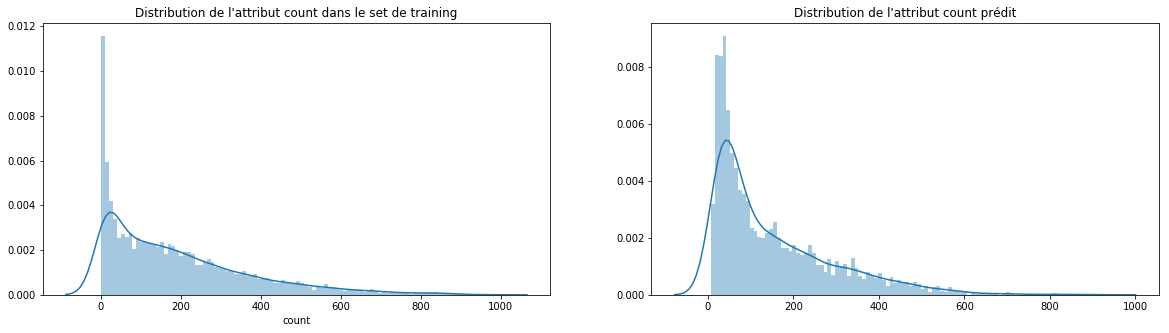

In [27]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels, ax=ax1, bins=100)
sn.distplot(np.exp(preds), ax=ax2, bins=100)
ax1.set(title="Distribution de l'attribut count dans le set de training")
ax2.set(title="Distribution de l'attribut count prédit")